In [1]:
# compare_countries_analysis.py / or paste into a Jupyter notebook cell
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# --- User-configurable paths (place your cleaned CSVs here) ---
data_paths = {
    "Benin": "../data/benin-malanville.csv",
    "Sierra Leone": "../data/sierraleone-bumbuna.csv",
    "Togo": "../data/togo-dapaong_qc.csv"
}

In [3]:
# --- Load datasets ---
dfs = {}
missing = []
for country, path in data_paths.items():
    if os.path.exists(path):
        try:
            dfs[country] = pd.read_csv(path)
        except Exception as e:
            missing.append(f"{country} (error reading: {e})")
    else:
        missing.append(country)

if missing:
    print("Warning: The following datasets were not found or couldn't be read:")
    for m in missing:
        print(" -", m)
    print("\nPlease put the cleaned CSVs at the paths above and re-run.\n")

if not dfs:
    raise FileNotFoundError("No country CSVs were found. Place the cleaned CSVs and re-run.")

In [4]:
# --- Validate metric columns and coerce numeric ---
metrics = ["GHI", "DNI", "DHI"]
for country, df in dfs.items():
    for m in metrics:
        if m not in df.columns:
            raise KeyError(f"Metric '{m}' not found in {country} dataset. Columns: {list(df.columns)}")
        df[m] = pd.to_numeric(df[m], errors='coerce')

In [5]:
# --- Summary table (mean, median, std) ---
summary_rows = []
for country, df in dfs.items():
    row = {"country": country}
    for m in metrics:
        ser = df[m].dropna()
        row[f"{m}_mean"] = ser.mean()
        row[f"{m}_median"] = ser.median()
        row[f"{m}_std"] = ser.std(ddof=1)
    summary_rows.append(row)
summary_df = pd.DataFrame(summary_rows).set_index("country")
print("Summary table (mean, median, std):")
print(summary_df.round(3))

Summary table (mean, median, std):
              GHI_mean  GHI_median  GHI_std  DNI_mean  DNI_median  DNI_std  \
country                                                                      
Benin          240.559         1.8  331.131   167.188        -0.1  261.711   
Sierra Leone   201.958         0.3  298.495   116.376        -0.1  218.653   
Togo           230.555         2.1  322.532   151.258         0.0  250.957   

              DHI_mean  DHI_median  DHI_std  
country                                      
Benin          115.359         1.6  158.691  
Sierra Leone   113.721        -0.1  158.946  
Togo           116.444         2.5  156.521  


C:\Users\hp\AppData\Local\Temp\ipykernel_10756\3080046930.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_for_plot, labels=list(dfs.keys()), vert=True)


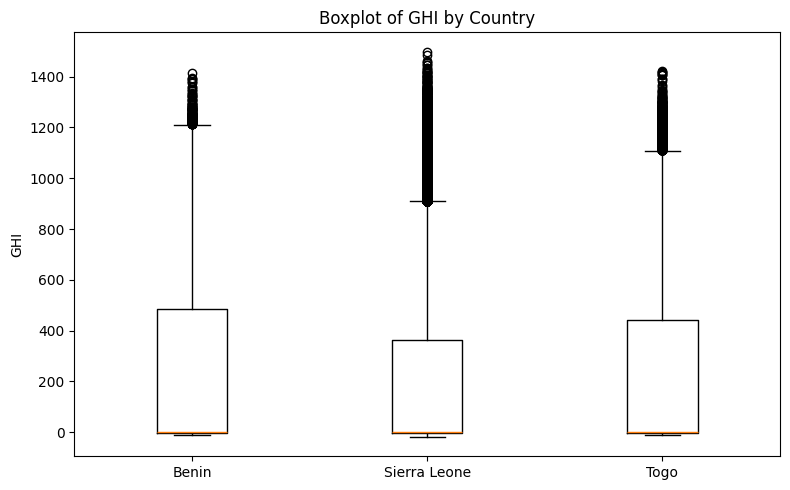

C:\Users\hp\AppData\Local\Temp\ipykernel_10756\3080046930.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_for_plot, labels=list(dfs.keys()), vert=True)


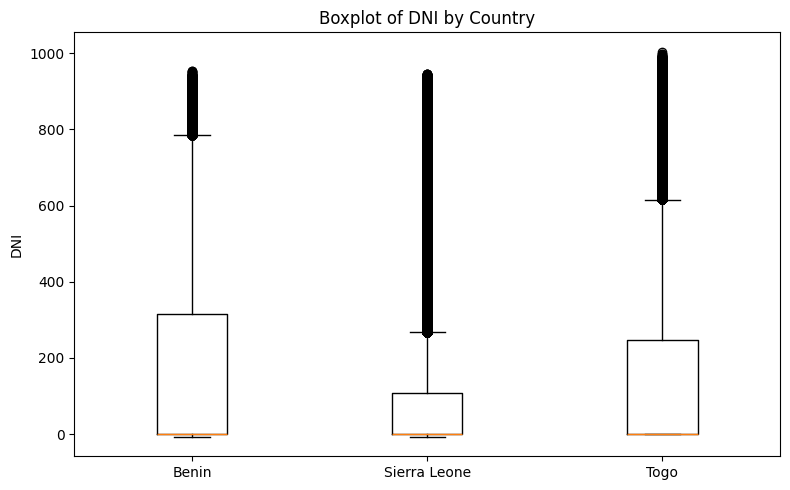

C:\Users\hp\AppData\Local\Temp\ipykernel_10756\3080046930.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_for_plot, labels=list(dfs.keys()), vert=True)


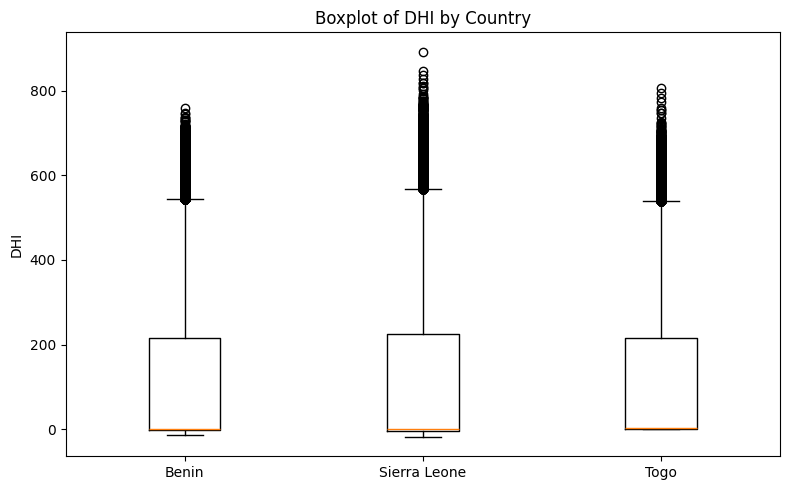

In [7]:
import os


os.makedirs("data", exist_ok=True)  # ✅ Create the folder if missing

plot_files = []
for m in metrics:
    fig, ax = plt.subplots(figsize=(8,5))
    data_for_plot = [dfs[c][m].dropna() for c in dfs.keys()]
    ax.boxplot(data_for_plot, labels=list(dfs.keys()), vert=True)
    ax.set_title(f"Boxplot of {m} by Country")
    ax.set_ylabel(m)
    plt.tight_layout()

    fname = os.path.join("data", f"boxplot_{m}.png")
    fig.savefig(fname)   
    plot_files.append(fname)

    plt.show()
    plt.close(fig)

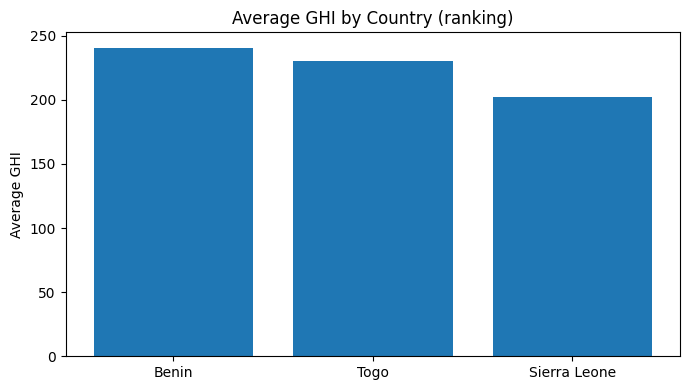

In [8]:
# --- Small bar chart ranking countries by average GHI ---
fig, ax = plt.subplots(figsize=(7,4))
ghi_means = summary_df["GHI_mean"].sort_values(ascending=False)
ax.bar(ghi_means.index, ghi_means.values)
ax.set_title("Average GHI by Country (ranking)")
ax.set_ylabel("Average GHI")
plt.tight_layout()
barfile = os.path.join("data", "avg_ghi_ranking.png")
fig.savefig(barfile)
plot_files.append(barfile)
plt.show()
plt.close(fig)

In [9]:
# --- Statistical testing on GHI ---
ghi_groups = [dfs[c]["GHI"].dropna() for c in dfs.keys()]
anova_result = None
kruskal_result = None
if len(ghi_groups) >= 2 and all([len(g) > 1 for g in ghi_groups]):
    try:
        anova_result = stats.f_oneway(*ghi_groups)
    except Exception as e:
        anova_result = f"ANOVA error: {e}"
    try:
        kruskal_result = stats.kruskal(*ghi_groups)
    except Exception as e:
        kruskal_result = f"Kruskal-Wallis error: {e}"
else:
    print("Not enough data to run ANOVA/Kruskal-Wallis (need at least 2 groups with >1 sample each).")

print("\nStatistical tests on GHI:")
print("ANOVA result:", anova_result)
print("Kruskal-Wallis result:", kruskal_result)


Statistical tests on GHI:
ANOVA result: F_onewayResult(statistic=np.float64(2090.0928704796274), pvalue=np.float64(0.0))
Kruskal-Wallis result: KruskalResult(statistic=np.float64(4524.883491942792), pvalue=np.float64(0.0))


In [12]:
# --- Key observations (3 short bullets) ---
medians = {f"{m}_median": summary_df[f"{m}_median"].idxmax() for m in metrics}
variabilities = {f"{m}_std": summary_df[f"{m}_std"].idxmax() for m in metrics}
observations = [
    f"{medians['GHI_median']} shows the highest median GHI among the included countries.",

f"{variabilities['GHI_std']} has the largest standard deviation (most variability) in GHI.",
    "Check ANOVA (parametric) and Kruskal-Wallis (nonparametric) p-values to assess whether GHI differences are statistically significant."
]
print("\nKey observations:")
for o in observations:
    print("-", o)


Key observations:
- Togo shows the highest median GHI among the included countries.
- Benin has the largest standard deviation (most variability) in GHI.
- Check ANOVA (parametric) and Kruskal-Wallis (nonparametric) p-values to assess whether GHI differences are statistically significant.


In [13]:
summary_df.to_csv("data/summary_metrics.csv", index=True)